<a href="https://colab.research.google.com/github/arjuzzcolab/REACT-PROJECTS/blob/main/test_final_combined_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Concatenate, Dropout

### Extract Domain Part of URL and assign labels

In [ ]:
# Function to load URLs from a DataFrame and assign labels
from urllib.parse import urlparse
def load_urls_and_labels_from_df(dataframe, label_column, label_mapping):
    urls = dataframe['Data'].tolist()
    categories = dataframe['Category'].tolist()

    # Map categories to numerical labels
    labels = [label_mapping[category] for category in categories]

    preprocessed_urls = [parsed_url.netloc for url in urls if (parsed_url := urlparse(url if '://' in url else 'http://' + url.strip())).netloc]

    return preprocessed_urls, labels


# Path to the Excel file containing URLs and categories
excel_file_path = 'URL.xlsx'  # Replace with the actual file path

# Load data from Excel file
df = pd.read_excel(excel_file_path)

# Define label mapping (assuming 'ham' is 0 and 'spam' is 1)
label_mapping = {'ham': 0, 'spam': 1}

# Load URLs and labels with corresponding mapping
urls, labels = load_urls_and_labels_from_df(df, label_column='category', label_mapping=label_mapping)


# Save preprocessed URLs to a file
output_file_path = 'preprocessed_urls.txt'
with open(output_file_path, 'w') as file:
    for url in urls:
        file.write(url + '\n')


In [ ]:
# Calculate the mode and mean length of the URL dataset
url_lengths = [len(url) for url in urls]

# Calculate mode
mode_length = max(set(url_lengths), key=url_lengths.count)

# Calculate mean
mean_length = sum(url_lengths) / len(url_lengths)

print(f"Mode URL Length: {mode_length}")
print(f"Mean URL Length: {mean_length}")

Mode URL Length: 14
Mean URL Length: 19.739294293963372


In [ ]:
# Calculate the median length of the URL dataset
sorted_lengths = sorted(url_lengths)
length_count = len(sorted_lengths)

if length_count % 2 == 0:
    # If the length is even, calculate the average of the middle two values
    median_length = (sorted_lengths[length_count // 2 - 1] + sorted_lengths[length_count // 2]) / 2
else:
    # If the length is odd, select the middle value
    median_length = sorted_lengths[length_count // 2]

print(f"Median URL Length: {median_length}")

Median URL Length: 17


### Length Distribution of URL

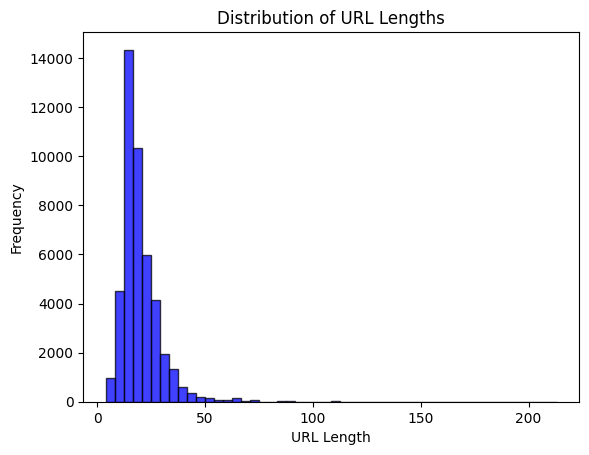

In [ ]:
import matplotlib.pyplot as plt

# Assuming you already have the 'urls' variable containing your URLs
url_lengths = [len(url) for url in urls]

# Plot a histogram to visualize the distribution of URL lengths
plt.hist(url_lengths, bins=50, alpha=0.75, color='b', edgecolor='black')
plt.xlabel('URL Length')
plt.ylabel('Frequency')
plt.title('Distribution of URL Lengths')
plt.show()

# Analyze the plot and set a max sequence length based on your requirements
max_sequence_length = 50
 # Set your desired max sequence length

# Trim URLs to the chosen max sequence length
trimmed_urls = [url[:max_sequence_length] for url in urls]

# Now 'trimmed_urls' contains the URLs trimmed to the chosen max sequence length


### Class distribution of URL

In [ ]:
import pandas as pd

# Assuming your labels are in a column named 'label' in a DataFrame
class_distribution = df['Category'].value_counts()

print("Class Distribution:")
print(class_distribution)

Class Distribution:
Category
ham     22687
spam    22686
Name: count, dtype: int64


### Padding with PAD token and replacing less frequent characters with UNK token

In [ ]:
# Create a set of all characters in the URLs
all_characters = set(''.join(urls))

# Replace less frequent characters with <UNK>
frequency_threshold = 100
character_counts = {char: 0 for char in all_characters}
for url in urls:
    for char in url:
        character_counts[char] += 1

# Modify the URLs by replacing less frequent characters with <UNK>
for i in range(len(urls)):
    for char, count in character_counts.items():
        if count < frequency_threshold:
            urls[i] = urls[i].replace(char, '<UNK>')

# Obtain M unique characters including <UNK> and <PAD>
unique_characters = list(set(''.join(urls)))
unique_characters += ['<UNK>', '<PAD>']
M = len(unique_characters)

# Set the length of the sequence L1 to 100 characters
L1 = 50

# Truncate URLs longer than 100 characters
urls_truncated = [url[:L1] for url in urls]

# Now, 'urls_truncated' contains the modified URLs, and 'labels' contains corresponding numerical labels.

### URL tokenizer and shuffling of dataset to introduce randomness

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Shuffle the data
indices = np.arange(len(urls_truncated))
np.random.shuffle(indices)

# Shuffle URLs and labels accordingly
shuffled_urls = [urls_truncated[i] for i in indices]
shuffled_labels = [labels[i] for i in indices]

tokenizer = Tokenizer(char_level=True, oov_token='<UNK>')
tokenizer.fit_on_texts(shuffled_urls)
sequences = tokenizer.texts_to_sequences(shuffled_urls)
padded_sequences = pad_sequences(sequences, maxlen=L1, padding='post', truncating='post')

# Read the Excel file into a DataFrame
ddf = pd.read_excel('data1.xlsx')

# Shuffle DataFrame rows based on the shuffled indices
shuffled_dataset = ddf.iloc[indices].reset_index(drop=True)

# Extract data from the third column to the last column
ddf = shuffled_dataset.iloc[:, 3:]


In [ ]:
print(padded_sequences[5])

[10 12 20  3 11  3  4  8 11 15 18 12  3  2  6  3 10  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]


### Splitting dataset

In [ ]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X = padded_sequences
y = shuffled_labels
X_numeric = ddf.values
print(X_numeric)

X_numeric_train, X_numeric_test, X_train, X_test, X_train_char, X_test_char, y_train, y_test = train_test_split(X_numeric, shuffled_urls, X, y, test_size=0.2, random_state=42)


[[ 0  3 14  3  0  1]
 [ 0  2 15  3  0  0]
 [ 0  4 17  5  0  0]
 ...
 [ 0  2 21  3  0  0]
 [ 0  1  9  2  0  0]
 [ 0  3 10  3  0  0]]


### Creating n-gram feature vector of URL

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# X_train_list = X_train.tolist()
# X_test_list = X_test.tolist()

# Define the n-gram range and maximum number of features
ngram_range = (2, 5)  # Consider n-grams of length 2 to 5
max_features = 1000  # Maximum number of features

# Initialize CountVectorizer to extract n-grams
vectorizer = CountVectorizer(analyzer='char', ngram_range=ngram_range, max_features=max_features)

# Convert X_train to a list of strings if it's a NumPy array
X_train_list = X_train.tolist() if isinstance(X_train, np.ndarray) else X_train
X_train_list = [str(item) for item in X_train_list]

X_test_list = X_test.tolist() if isinstance(X_test, np.ndarray) else X_test
X_test_list = [str(item) for item in X_test_list]
# Fit the vectorizer on your training data
vectorizer.fit(X_train_list)

# Transform the training and testing data into n-gram representations
X_train_ngram = vectorizer.transform(X_train_list)
X_test_ngram = vectorizer.transform(X_test_list)

# Convert the sparse matrices to dense arrays
X_train_ngram = X_train_ngram.toarray()
X_test_ngram = X_test_ngram.toarray()

# Initialize CountVectorizer to extract n-grams
vectorizer = CountVectorizer(analyzer='char', ngram_range=ngram_range, max_features=max_features)



# Print the shape of the n-gram matrix
print("Shape of X_train_ngram:", X_train_ngram.shape)


Shape of X_train_ngram: (36298, 1000)


In [ ]:

vectorizer.fit(X_train_list)
num_ngrams = len(vectorizer.vocabulary_)

# Print the total number of unique n-grams
print("Total number of unique n-grams:", num_ngrams)

Total number of unique n-grams: 1000


### Input and Embedding Layer

In [ ]:
max_sequence_length_char = 50
max_sequence_length_ngram = 1000
embedding_dim = 32
num_filters = 256
filter_sizes = [3,4,5]

# Define input layer
input_layer_char = Input(shape=(max_sequence_length_char,))
input_layer_ngram = Input(shape=(max_sequence_length_ngram,))
input_layer_numeric = Input(shape=(6,))

# Character embedding layer
embedding_layer_char = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim)(input_layer_char)

# N-gram embedding layer
embedding_layer_ngram = Embedding(input_dim=1000, output_dim=embedding_dim)(input_layer_ngram)

### Convolutional Layer

In [ ]:
# Convolutional blocks for character embedding
conv_blocks_char = []
for filter_size in filter_sizes:
    conv_layer = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu')(embedding_layer_char)
    maxpool_layer = MaxPooling1D(pool_size=max_sequence_length_char - filter_size + 1)(conv_layer)
    conv_blocks_char.append(maxpool_layer)

# Convolutional blocks for n-gram embedding
conv_blocks_ngram = []
for filter_size in filter_sizes:
    conv_layer = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu')(embedding_layer_ngram)
    maxpool_layer = MaxPooling1D(pool_size=max_sequence_length_ngram - filter_size + 1)(conv_layer)
    conv_blocks_ngram.append(maxpool_layer)

### Concatenation of features

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Concatenate, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.models import Model

# Concatenate the outputs from different filter sizes for both character and n-gram embeddings
concatenated_char = Concatenate()(conv_blocks_char)
concatenated_ngram = Concatenate()(conv_blocks_ngram)

# Reshape numeric input
reshaped_input_layer_numeric = Reshape((1, 6))(input_layer_numeric)

# Concatenate the outputs from character and n-gram embeddings
concatenated_output = Concatenate()([concatenated_char, concatenated_ngram, reshaped_input_layer_numeric])


### Attention Layer

In [ ]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, dropout_rate=0.1, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="glorot_normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x, mask=None):
        et = tf.squeeze(tf.tanh(tf.matmul(x, self.W) + self.b), axis=-1)
        if mask is not None:
            et += (1.0 - mask) * -1e9  # Masked positions will have very negative scores
        at = tf.nn.softmax(et)
        at = tf.expand_dims(at, axis=-1)
        output = x * at
        output = tf.reduce_sum(output, axis=1)
        output = self.layer_norm(output)
        output = self.dropout(output)
        return output


# Apply attention mechanism
attention_output = AttentionLayer()(concatenated_output)

### Neural Network Classifier

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout


# First fully connected layer
dense_layer1 = Dense(256, activation='relu')(attention_output)
dropout_layer1 = Dropout(0.3)(dense_layer1)

# Second fully connected layer
dense_layer2 = Dense(128, activation='relu')(dropout_layer1)
dropout_layer2 = Dropout(0.3)(dense_layer2)


# Output layer
output_layer = Dense(1, activation='sigmoid')(dropout_layer2)


# Create the model
model = Model(inputs=[input_layer_char, input_layer_ngram, input_layer_numeric], outputs=output_layer)

# Convert data to numpy arrays
X_train_char = np.array(X_train_char)
X_train_ngram = np.array(X_train_ngram)
X_numeric_train = np.array(X_numeric_train)
y_train = np.array(y_train)

X_test_char = np.array(X_test_char)
X_test_ngram = np.array(X_test_ngram)
X_numeric_test = np.array(X_numeric_test)
y_test = np.array(y_test)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit([X_train_char, X_train_ngram, X_numeric_train], y_train, epochs=10, batch_size=20, validation_data=([X_test_char, X_test_ngram, X_numeric_test], y_test))

# Evaluate the model
loss, accuracy = model.evaluate([X_test_char, X_test_ngram, X_numeric_test], y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 50, 32)               1376      ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1000, 32)             32000     ['input_2[0][0]']             
                                                                                            

In [ ]:
# Get the weights of the first embedding layer
weights_1 = model.layers[2].get_weights()[0]

# Get the weights of the second embedding layer
weights_2 = model.layers[3].get_weights()[0]

# Print the shape of the weights matrices
print("Shape of embedding weights 1:", weights_1.shape)
print("Shape of embedding weights 2:", weights_2.shape)

# Print the actual values of the embedding weights
print("Embedding weights 1:")
print(weights_1)

print("Embedding weights 2:")
print(weights_2)

Shape of embedding weights 1: (43, 32)
Shape of embedding weights 2: (1000, 32)
Embedding weights 1:
[[-0.06149007  0.17256711  0.091538   ... -0.10752389  0.14711797
  -0.02826824]
 [ 0.00900948 -0.03682099 -0.01700206 ...  0.0362798   0.01429966
  -0.01602372]
 [-0.20602524 -0.22160342  0.13518287 ...  0.11349261 -0.01278456
   0.20258923]
 ...
 [-0.95781374 -1.0511706   0.77121705 ...  0.8795882  -0.02033276
  -0.6771403 ]
 [-0.06456602  0.3792075  -0.06553914 ... -0.02154436  0.14742613
  -0.05509058]
 [-0.25109634  0.01632992  0.07640485 ...  0.19915983 -0.02864552
  -0.16186872]]
Embedding weights 2:
[[ 0.04130276  0.02248506 -0.02982323 ... -0.01680593 -0.01642029
  -0.01785316]
 [ 0.02158655 -0.22800562 -0.03567053 ...  0.16374841 -0.03740771
  -0.04158231]
 [-0.03918364  0.01114888  0.06015736 ... -0.03613827  0.05053885
  -0.09588132]
 ...
 [ 0.00666983 -0.00816164 -0.04869831 ...  0.02458859  0.02445887
  -0.04510163]
 [-0.04531113 -0.00763266  0.00807869 ... -0.02366802  0.

In [ ]:
from sklearn.metrics import confusion_matrix

# Make predictions on the test data
y_pred = model.predict([X_test_char, X_test_ngram,X_numeric_test])

# Convert the predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Extract TP, FP, TN, FN from the confusion matrix
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

# Compute TPR and FPR
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
# Compute TNR
TNR = TN / (TN + FP)

# Compute FNR
FNR = FN / (FN + TP)

# Print TNR and FNR
print("True Negative Rate (TNR):", TNR)
print("False Negative Rate (FNR):", FNR)
# Print TPR and FPR
print("True Positive Rate (TPR):", TPR)
print("False Positive Rate (FPR):", FPR)


# Compute precision
precision = TP / (TP + FP)

# Print precision
print("Precision:", precision)


284/284 [==============================] - 3s 10ms/step
True Negative Rate (TNR): 0.9499125109361329
False Negative Rate (FNR): 0.0657339551410171
True Positive Rate (TPR): 0.9342660448589829
False Positive Rate (FPR): 0.050087489063867015
Precision: 0.9483769161406672


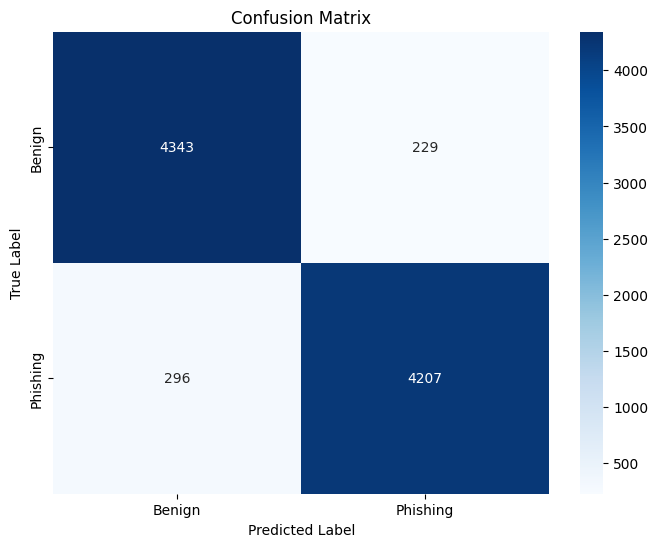

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define classes
classes = ['Benign', 'Phishing']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score, recall_score, f1_score

# Predict probabilities for the test set
y_pred_probs = model.predict([X_test_char, X_test_ngram, X_numeric_test])

# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_probs)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("AUC:", auc)
print("Recall:", recall)
print("F1 score:", f1)


1474/1474 [==============================] - 10s 7ms/step
AUC: 0.9433417246083585
Recall: 0.9890004429351839
F1 score: 0.9241859823399559


In [ ]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

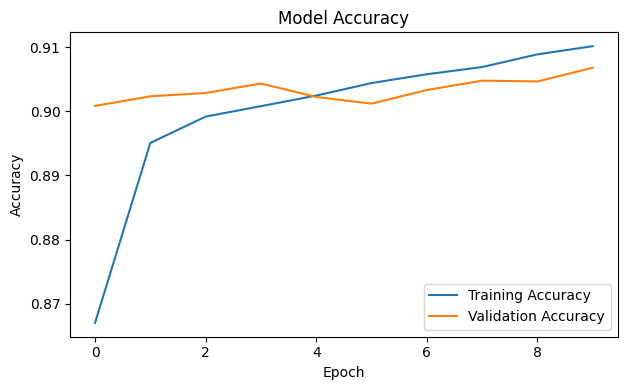

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))



# Plot training & validation accuracy valuesa
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Saving the model

In [ ]:
model_save_path = '/content/drive/My Drive/model/cnnmodel2.h5'

# Save the model
model.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model


# Define your custom attention layer class
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, dropout_rate=0.1, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="glorot_normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x, mask=None):
        et = tf.squeeze(tf.tanh(tf.matmul(x, self.W) + self.b), axis=-1)
        if mask is not None:
            et += (1.0 - mask) * -1e9  # Masked positions will have very negative scores
        at = tf.nn.softmax(et)
        at = tf.expand_dims(at, axis=-1)
        output = x * at
        output = tf.reduce_sum(output, axis=1)
        output = self.layer_norm(output)
        output = self.dropout(output)
        return output

# Define a custom object scope to register the custom layer
with tf.keras.utils.custom_object_scope({'AttentionLayer': AttentionLayer}):
    # Load the entire model
    loaded_model = load_model('/content/drive/MyDrive/model/cnnmodel2.h5')


### Predict

In [ ]:
# 5.Gives number of '/' in URL (URL_Depth)
def getDepth(url):
    # Split the path of the URL on the dot character
    parsed_url = urlparse(url if '://' in url else 'http://' + url.strip())
    dom_url = parsed_url.netloc
    s = dom_url.split('.')
    depth = 0
    for part in s:
        if part:
            depth += 1

    return depth

In [ ]:
# 6.Checking for redirection '//' in the url (Redirection)
def redirection(url):
  pos = url.rfind('//')
  if pos > 6:
    if pos > 7:
      return 1
    else:
      return 0
  else:
    return 0

In [ ]:
#listing shortening services
shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnchS\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"

In [ ]:
# 8. Checking for Shortening Services in URL (Tiny_URL)
def tinyURL(url):
    match=re.search(shortening_services,url)
    if match:
        return 1
    else:
        return 0

In [ ]:
def count_hyphens(url):
    urld =  url.split('/')[0]
    return urld.count('-')

### change in url depth

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import re

new_url = "s18p3x76.duckdns.org"
tdf = pd.DataFrame(columns=["has_ip","special_and_numbers_count","depth","shortened_url","hyphen_count"])

ip_pattern = r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b'

# Check if the URL contains an IP address pattern
tdf.loc[0, 'has_ip'] = int(bool(re.search(ip_pattern, new_url)))

tdf.loc[0, 'special_and_numbers_count'] = sum(not c.isalpha() for c in new_url)

tdf.loc[0, 'url_length'] = len(new_url)

var = getDepth(new_url)
tdf.loc[0, 'depth'] = var

# tdf.loc[0, 'redirection'] = redirection(new_url)

tdf.loc[0, 'shortened_url'] = tinyURL(new_url)

tdf.loc[0, 'hyphen_count'] = count_hyphens(new_url)


print(tdf.iloc[0])

# # Normalization using MinMaxScaler
# scaler = MinMaxScaler()
# tdf[['special_and_numbers_count', 'url_length', 'depth','hyphen_count']] = scaler.fit_transform(tdf[['special_and_numbers_count', 'url_length', 'depth','hyphen_count']])

has_ip                          0
special_and_numbers_count       7
depth                           3
shortened_url                   0
hyphen_count                    0
url_length                   20.0
Name: 0, dtype: object


In [ ]:
def preprocess(new_url):
  # Preprocessing steps
  # Replace less frequent characters with '<UNK>'
  for char in new_url:
      if char not in unique_characters:
          new_url = new_url.replace(char, '<UNK>')

  # Tokenize the new URL
  new_url_sequence = tokenizer.texts_to_sequences([new_url])

  # Pad the sequence to the same length as the training data
  new_url_padded = pad_sequences(new_url_sequence, maxlen=50, padding='post', truncating='post')
  return new_url_padded

In [ ]:
# Import necessary libraries
from sklearn.feature_extraction.text import CountVectorizer

def getngram(new_url):

  # Define the n-gram range and maximum number of features
  ngram_range = (2, 5)  # Consider n-grams of length 2 to 5
  max_features = 1000  # Maximum number of features

  # Initialize CountVectorizer to extract n-grams
  vectorizer = CountVectorizer(analyzer='char', ngram_range=ngram_range, max_features=max_features)

  # Convert the new URL to a list of strings
  new_url_list = [new_url]

  # Fit the vectorizer on your training data
  vectorizer.fit(X_train_list)

  # Transform the new URL into n-gram representation using the fitted CountVectorizer
  new_url_ngram = vectorizer.transform(new_url_list)

  # Convert the sparse matrix to a dense array
  new_url_ngram = new_url_ngram.toarray()

  # Print the shape of the n-gram matrix
  print("Shape of new_url_ngram:", new_url_ngram.shape)
  return new_url_ngram


In [ ]:
def get_domain(url):
    parsed_url = urlparse(url if '://' in url else 'http://' + url.strip())
    return parsed_url.netloc


In [ ]:
# from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Concatenate, Flatten, Dense, Dropout, Reshape
# from tensorflow.keras.models import Model

# # Make predictions
# def predict(new_url):
#   url_dom = get_domain(new_url)
#   new_url_padded = preprocess(url_dom)
#   new_url_ngram = getngram(url_dom)
#   new_url_padded = np.array(new_url_padded)
#   new_url_ngram = np.array(new_url_ngram)
#   max_sequence_length_char = 40
#   tdf_values = [tdf.values.tolist()[0]]
#   tdf_values = np.array(tdf_values)

#   # max_sequence_length_ngram = len(vectorizer.vocabulary_)
#   # embedding_dim = 32 #16
#   # num_filters = 128
#   # filter_sizes = [3,4,5]

#   # char_data = np.array([new_url_padded])  # Assuming single sample
#   # ngram_data = np.array([new_url_ngram])  # Assuming single sample

#   # # Step 3: Pass Input Data through Embedding Layers
#   # embedded_char_data = embedding_layer_char(char_data)
#   # embedded_ngram_data = embedding_layer_ngram(ngram_data)

#   # # Convolutional blocks for character embedding
#   # conv_blocks_char = []
#   # for filter_size in filter_sizes:
#   #     conv_layer = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu')(embedding_layer_char)
#   #     maxpool_layer = MaxPooling1D(pool_size=max_sequence_length_char - filter_size + 1)(conv_layer)
#   #     conv_blocks_char.append(maxpool_layer)

#   # # Convolutional blocks for n-gram embedding
#   # conv_blocks_ngram = []
#   # for filter_size in filter_sizes:
#   #     conv_layer = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu')(embedding_layer_ngram)
#   #     maxpool_layer = MaxPooling1D(pool_size=max_sequence_length_ngram - filter_size + 1)(conv_layer)
#   #     conv_blocks_ngram.append(maxpool_layer)

#   # # Concatenate the outputs from different filter sizes for both character and n-gram embeddings
#   # concatenated_char = Concatenate()(conv_blocks_char)
#   # concatenated_ngram = Concatenate()(conv_blocks_ngram)


#   # # Concatenate the outputs from character and n-gram embeddings
#   # concatenated_output = Concatenate()([concatenated_char, concatenated_ngram,tdf_values])

#   # attention_output = AttentionLayer()(concatenated_output)


#   # prediction = loaded_model.predict(attention_output)

#   prediction = loaded_model.predict([new_url_padded,new_url_ngram,tdf_values])

#   binary_prediction = (prediction > 0.5).astype(int)
#   print(new_url)
#   print(prediction)
#   print(binary_prediction)
#   print("Predicted Class:", "Malicious" if binary_prediction == 1 else "Benign")

In [ ]:
# Make predictions
def predict(new_url):
  new_url_padded = preprocess(new_url)
  new_url_ngram = getngram(new_url)
  tdf_values = [tdf.values.tolist()[0]]
  new_url_padded = np.array(new_url_padded)
  new_url_ngram = np.array(new_url_ngram)
  tdf_values = np.array(tdf_values)
  print(tdf_values)

  prediction = loaded_model.predict([new_url_padded,new_url_ngram,tdf_values])

  binary_prediction = (prediction > 0.5).astype(int)
  print(new_url)
  print(prediction)
  print(binary_prediction)
  print("Predicted Class:", "Malicious" if binary_prediction == 1 else "Benign")

In [ ]:
predict("s18p3x76.duckdns.org")

Shape of new_url_ngram: (1, 1000)
[[ 0.  7.  3.  0.  0. 20.]]
1/1 [==============================] - 0s 20ms/step
s18p3x76.duckdns.org
[[1.]]
[[1]]
Predicted Class: Malicious
